# Unsupervised Clustering of images

### What am i doing in this notebook?

Solving the problem "Star maps 2.0" with Yandex ML competition 2022. In the stellar galaxy, 9604 images were sent over a noisy channel. It is necessary to divide all the images into 983 clusters, it is known that each cluster contains from 7 to 10 images.

In this notebook, I will explore how I can give the computer a group of  images, and it can cluster the ones with the same together.

I will be doing that by encoding the images through a trained convolutional network, and then apply a Size Constrained KMeans clustering algorithm to the encoded features. We can then check the clusters and see if it worked!

### Let's import the libraries we'll need

Keras is using a TensorFlow backend in our case here.

In [ ]:

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

## Dataset information

The dataset consists 9604 of photographs and drawn images.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!ls

gdrive		      mo_output4000.pickle  mo_output8000.pickle  sample_data
mo_output2500.pickle  mo_output6000.pickle  resnet50v.pickle


In [ ]:
DIR = '/content/gdrive/MyDrive/E. Звёздные карты 2.0/dataset'

In [ ]:
import os
from PIL import Image

### Loading the images

Now we create a function that loads all images in a directory for a given array of codes in one array and creates the corresponding label array for them.

Loaded images are resized to 224 x 224 before storing them in our array since this is the size preferred by CNN which we will be using later.

In [ ]:
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images():

    # Define empty arrays where we will store our images and labels
    images = []
    file_names = [file for file in os.listdir(DIR)]
    for file in file_names:
            print(file)
            # build file path
            file_path = os.path.join(DIR, file)

            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 240 x 240 for EfficientNet
            #image = cv2.resize(image, (240,240))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)

    return images

In [ ]:
images = load_images()

Выходные данные были обрезаны до нескольких последних строк (5000).
2340.png
1176.png
8615.png
5570.png
4001.png
2076.png
3171.png
5067.png
0642.png
2507.png
6626.png
8025.png
4089.png
2401.png
9206.png
7413.png
4130.png
3867.png
3154.png
6627.png
9151.png
7899.png
3960.png
1636.png
8582.png
5081.png
8966.png
3322.png
5525.png
6029.png
9112.png
4818.png
7041.png
0776.png
9332.png
2479.png
0745.png
0735.png
0903.png
2065.png
7558.png
1489.png
2007.png
3464.png
4452.png
9396.png
8833.png
6556.png
6597.png
4067.png
5929.png
3245.png
7323.png
9083.png
3018.png
6869.png
5159.png
5818.png
6635.png
2089.png
5006.png
4937.png
3824.png
7453.png
4434.png
2659.png
7399.png
3377.png
6685.png
4220.png
4652.png
9386.png
4685.png
2287.png
2643.png
5091.png
2156.png
4746.png
1029.png
0250.png
5442.png
1214.png
3606.png
4368.png
4112.png
6655.png
7387.png
0828.png
8968.png
1039.png
6630.png
9239.png
9199.png
4144.png
0472.png
8532.png
3200.png
1978.png
2549.png
0017.png
0711.png
1889.png
7845.png
9226.

### Photo time!

The photos will not be in their original aspect ratio since we've resized them to fit what CNN needs.

In [ ]:
def show_random_images(images, number_of_images_to_show=2):

    for i in range(3):

        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, i))

        for image in range(number_of_images_to_show):
            random_indicies = random.choice(range(len(images)))

            axis[image].imshow(images[random_indicies])
        plt.show()

2 random images for code 0


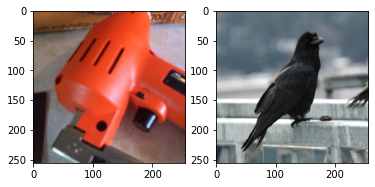

2 random images for code 1


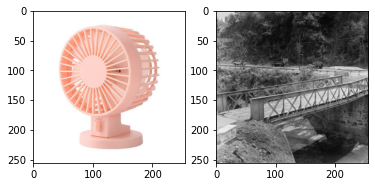

2 random images for code 2


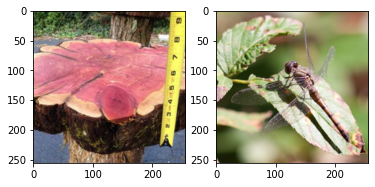

In [ ]:
show_random_images(images)

### Normalise...

We now convert the images and labels to NumPy arrays to make processing them easier. We then normaise the images before passing them on to CNN

### Load pre-trained covnet models
#### VGG16, VG19, ResNet50, EfficientNetB3...

We'll now load up the keras models with the imagenet weights. We'll remove the top dense layers, since we won't need to classify things here, and we just want these encoded features from the images.

In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential

net = EfficientNetB3(include_top=False, pooling='avg', weights='imagenet')
my_new_model = Sequential()
my_new_model.add(net)

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
# Say not to train first layer model. It is already trained
my_new_model.layers[0].trainable = False

In [ ]:
my_new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
Total params: 10,783,535
Trainable params: 0
Non-trainable params: 10,783,535
_________________________________________________________________


In [ ]:
%%time
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.models import Sequential

resnet = ResNet50V2(include_top=False, pooling='avg', weights='imagenet')
my_new_model = Sequential()
my_new_model.add(resnet)

CPU times: user 24 µs, sys: 1e+03 ns, total: 25 µs
Wall time: 29.1 µs


In [ ]:
# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

In [ ]:
tensorflow.keras.applications.resnet_v2 import preprocess_input
import cv2
import numpy as np
import pickle


resnet_feature_list = []
file_names = [file for file in os.listdir(DIR)]
i = 0
for file in file_names:
    file_path = os.path.join(DIR, file)
    print(i)
    i+=1
    im = cv2.imread(file_path)
    img = preprocess_input(np.expand_dims(im.copy(), axis=0))
    resnet_feature = my_new_model.predict(img)
    resnet_feature_np = np.array(resnet_feature)
    resnet_feature_list.append(resnet_feature_np.flatten())


array = np.array(resnet_feature_list)
array.shape
with open('resnet50v_output.pickle', 'wb') as f:
    pickle.dump(array, f)

In [ ]:
!pip install git+https://github.com/jingw2/size_constrained_clustering.git

In [ ]:
from k_means_constrained import KMeansConstrained

n_clusters = 983
model = minmax.MinMaxKMeansMinCostFlow(n_clusters, size_min=7,   size_max=10)
model.fit(resnet50_output)
centers = model.cluster_centers_
labels = model.labels_


In [ ]:
import pickle
with open('resnet50v.pickle', 'rb') as f:
    cnt = pickle.load(f)
cnt

array([711, 693, 970, ..., 157, 154, 874], dtype=int32)

In [ ]:
import collections

cnt = collections.Counter(cnt)
cnt

Counter({711: 8,
         693: 10,
         970: 10,
         168: 8,
         839: 10,
         11: 10,
         848: 10,
         731: 10,
         526: 10,
         522: 10,
         676: 10,
         417: 10,
         600: 10,
         612: 10,
         845: 10,
         606: 10,
         512: 9,
         812: 10,
         126: 10,
         138: 10,
         386: 10,
         537: 10,
         270: 10,
         398: 10,
         355: 10,
         969: 10,
         800: 10,
         847: 10,
         544: 10,
         500: 10,
         896: 10,
         798: 10,
         389: 10,
         550: 10,
         418: 6,
         210: 10,
         753: 10,
         177: 9,
         838: 10,
         504: 10,
         870: 10,
         628: 10,
         790: 10,
         351: 10,
         933: 10,
         405: 10,
         215: 9,
         344: 10,
         238: 10,
         291: 9,
         645: 10,
         680: 10,
         871: 9,
         844: 10,
         328: 10,
         640: 10,
 

## Result of Size Constrained KMeans clustering algorithm

2 random images for code 0


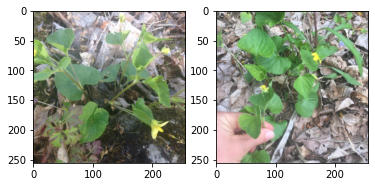

2 random images for code 1


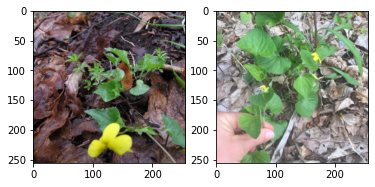

2 random images for code 2


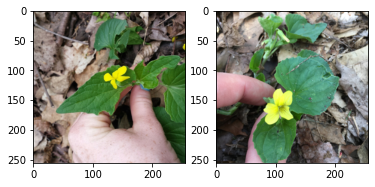

In [ ]:
idx = [ i for i in range(cnt.shape[0]) if cnt[i]==412]
tmp_img = [images[i] for i in idx]
show_random_images(tmp_img)

In [ ]:
import pandas as pd
file_names = [file for file in os.listdir(DIR)]
df = pd.DataFrame(columns=['filename','label'])
for i in range(len(file_names)):
  df.loc[i] = [file_names[i], cnt[i]]
df = df.sort_values(by=['filename'])
df.to_csv('submission.csv', index=False)


### PCA

Therefore, we rely on PCA to reduce dimensionality so that our clustering algorithms can cope with the memory limitation. In this task it was not possible to use PСA and obtain high quality clustering.

In [ ]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):

    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)

    return p

In [ ]:
# Create PCA instances for each covnet output
resnet50_pca = create_fit_PCA(resnet50_output)

In [ ]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

In [ ]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(resnet50_pca)

### Metrics

In [ ]:
from sklearn.metrics import accuracy_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    return "\nAccuracy: {0:0.8f}".format(acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))